In [3]:
#imports
import numpy as np
import pandas as pd
import logging
log = logging.getLogger(__name__)
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal, stats #filters
import scipy.fftpack #fft



#        ABR DATA         #


In [4]:
#Reproducibility
np.random.seed(1)

#axis1 = mV
#axis2 = L/R
#axis3 = db
#axis4 = Hz
#axis5 = rat
freqs = [0, 2000, 4000, 8000, 16000, 24000, 32000]
dbs = [90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25]

df_all = pd.DataFrame({'ratname':[],'frequency':[],'dB':[],'L/R':[],'ABR':[]})
for rat in ["R144863_090921", "R144883_091321", "R144884_091321"]:
   
    i = 0
    for f in (freqs):
        i = str(i)
        folder = "data_text_files/"
        path = folder + rat + "/"
        file = path + i +'.txt'
        fh = open(file, "r")
        j = 0
        while True:
            if fh.readline().startswith('Data Pnt:'):
                break
            j += 1
        df = pd.io.parsers.read_csv(file, skiprows=j)

        #Keeping only the column containing the average 
        df = df[[c for c in df.columns if c.startswith('Average(uV):')]]
        df.columns = np.arange(len(df.columns))

       
        # # check index for number of left and right entries????
        db = (pd.io.parsers.read_csv(file, skiprows = 7, header=None))[1:2].dropna(axis = 1)
        db1 = np.array(db)[:,1:].astype('int')

        d=0
        while True:
            if db1[:,d] >= 25:
                new_entry = {'ratname':rat,'frequency':f,'dB':db1[:,d],'L/R':'L','ABR':df.loc[:,d].to_numpy()}
                df_all = df_all.append(new_entry, ignore_index=True)
                d += 1
            if (db1[:,d] - db1[:,d+1]) < 0:
                d += 1
                break
            

        while True:
            if db1[:,d] >= 25:
                new_entry = {'ratname':rat,'frequency':f,'dB':db1[:,d],'L/R':'R','ABR':df.loc[:,d].to_numpy()}
                df_all = df_all.append(new_entry, ignore_index=True)
            d += 1
            if db1[:,d] < 25:
                break

        samples = len(df)
        fs = 25.00
        N = fs /2
        n = np.linspace(0, N, num=samples) 
        

/var/folders/w6/ctb_wk1170n35hbmsjzyx8080000gn/T/ipykernel_23728/981651971.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(new_entry, ignore_index=True)
/var/folders/w6/ctb_wk1170n35hbmsjzyx8080000gn/T/ipykernel_23728/981651971.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(new_entry, ignore_index=True)
/var/folders/w6/ctb_wk1170n35hbmsjzyx8080000gn/T/ipykernel_23728/981651971.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(new_entry, ignore_index=True)
/var/folders/w6/ctb_wk1170n35hbmsjzyx8080000gn/T/ipykernel_23728/981651971.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

In [35]:
#tested to ensure data drame accurately represents text files

df_all[518:533]

,ratname,frequency,dB,L/R,ABR
518,R144884_091321,16000.0,[90],R,"[-0.0682, -0.0609, -0.0535, -0.0667, -0.0617, ..."
519,R144884_091321,16000.0,[85],R,"[-0.0892, -0.101, -0.1088, -0.1115, -0.0947, -..."
520,R144884_091321,16000.0,[80],R,"[-0.0981, -0.0882, -0.0898, -0.0897, -0.0975, ..."
521,R144884_091321,16000.0,[75],R,"[-0.392, -0.4034, -0.3748, -0.3534, -0.3307, -..."
522,R144884_091321,16000.0,[70],R,"[0.1833, 0.1699, 0.1353, 0.1312, 0.1115, 0.091..."
523,R144884_091321,16000.0,[65],R,"[-0.2619, -0.2646, -0.2661, -0.2367, -0.2295, ..."
524,R144884_091321,16000.0,[60],R,"[-0.0532, -0.0653, -0.0683, -0.0693, -0.0862, ..."
525,R144884_091321,16000.0,[55],R,"[0.2088, 0.2186, 0.2396, 0.2766, 0.3037, 0.321..."
526,R144884_091321,16000.0,[50],R,"[0.1591, 0.1436, 0.1278, 0.1167, 0.1116, 0.106..."
527,R144884_091321,16000.0,[45],R,"[-0.122, -0.1224, -0.1042, -0.081, -0.0631, -0..."


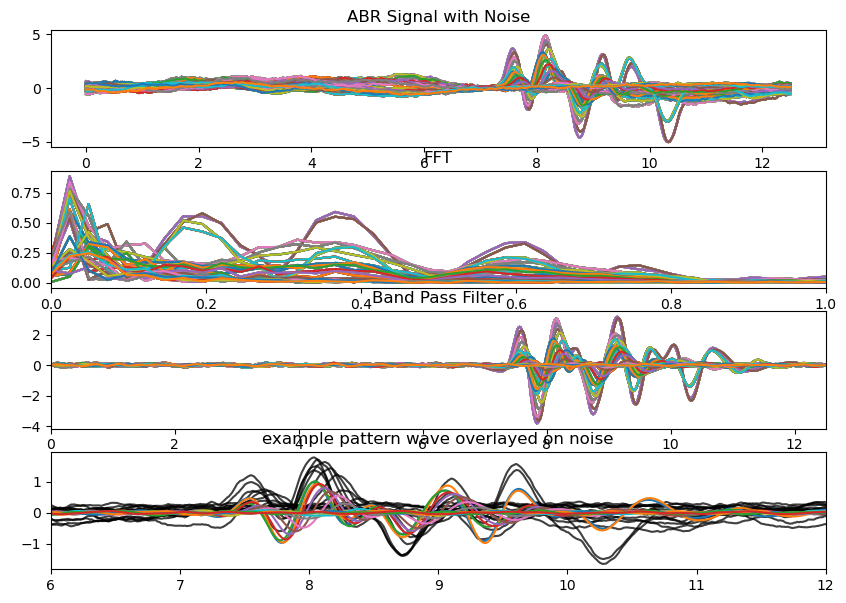

In [36]:
N = 1024
T = 1.0 / fs
x = np.linspace(0.0, N*T, N)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


#create figure
fig, ax = plt.subplots(4, 1, figsize=(10,7))

i = 0
r = 0
for r in range(len(rat)):
    for i in range(28):
        data = df_all.loc[i]["ABR"]


        plt.subplot(411)
        plt.plot(n, data)
        plt.title("ABR Signal with Noise")
        plt.grid()
       

        #fft
        yf = scipy.fftpack.fft(data)
        plt.subplot(412)
        plt.plot(xf, 2.0/N * np.abs(yf[0:samples//2]))
        plt.title("FFT")
        plt.grid()
        plt.xlim(0,1)

        #bandpass
        b, a = scipy.signal.butter(3, [.02, .09], 'band')
        filteredBandPass = scipy.signal.filtfilt(b, a, data)
        plt.subplot(413)
        plt.plot(n, filteredBandPass)
        plt.title("Band Pass Filter")
        plt.margins(0, .05)


        #iterate
        i += 0
    r +=1



# #example abr wave form overlayed on noise
# j=0

# #noise data
for j in range(14): 
    data = df_all.loc[518+j]["ABR"]
    plt.subplot(414)
    plt.plot(n, data, color = 'black', alpha = .75)
    plt.xlim(6,12)
    j +=1

#filtered data
j=0
for j in range(14): 
    data = df_all.loc[518+j]["ABR"]
    filteredBandPass = scipy.signal.filtfilt(b, a, data)
    plt.subplot(414)
    plt.plot(n,filteredBandPass)
    plt.title("example pattern wave overlayed on noise")
    plt.xlim(6,12)
    j +=1

#show figure
plt.show()



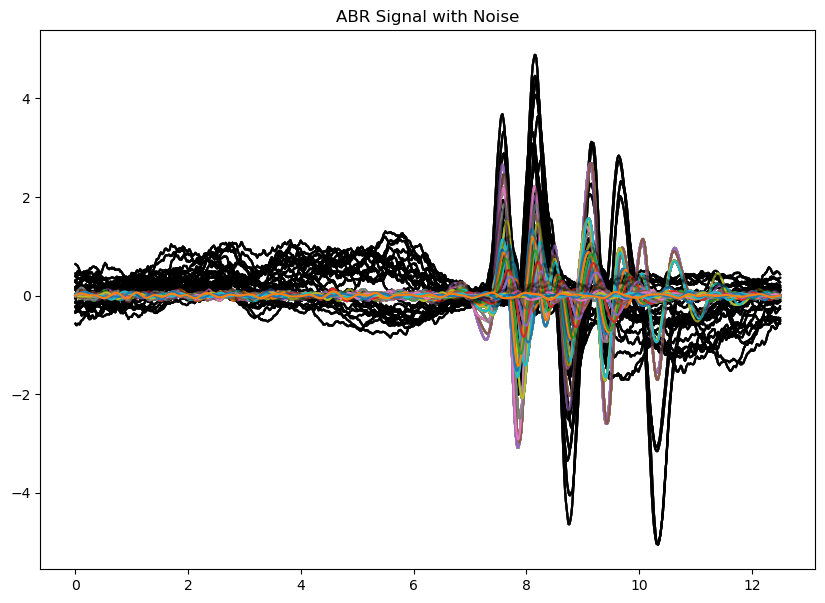

In [69]:
#create figure
fig, ax = plt.subplots(1, 1, figsize=(10,7))

i = 0
r = 0
for r in range(len(rat)):
    for i in range(28):
        data = click[i] 

        plt.subplot(111)

        plt.plot(n, data, color = 'black', alpha= .25)
       
        plt.title("ABR Signal with Noise")
        plt.grid()
       
        # #bandpass
        # plt.subplot(212)
        b, a = scipy.signal.butter(3, [.033, .09], 'band')
        filteredBandPass = scipy.signal.filtfilt(b, a, data)
        plt.plot(n, filteredBandPass)
        # plt.title("Filter data")
        # plt.xlim(2,12)

        #iterate
        i += 0
    r +=1

#show figure

plt.show()

In [35]:
#testing indexing
# 
# left = df_all.loc[df_all['L/R'] == "L"]["ABR"]
# left[13:18]
# twoK = df_all.loc[df_all['frequency'] == 2000]["ABR"]
# plt.plot(n, twokK[i], color = 'r')


13    [0.4083, 0.4664, -0.0699, -0.3715, -0.0233, -0...
28    [0.638, 0.447, -0.0253, -0.3476, -0.0401, -0.0...
29    [0.63, 0.4512, -0.017, -0.3116, -0.11, -0.0361...
30    [0.6166, 0.4638, -0.0225, -0.3077, -0.1736, -0...
31    [0.607, 0.4891, -0.0191, -0.2972, -0.2155, 0.0...
Name: ABR, dtype: object

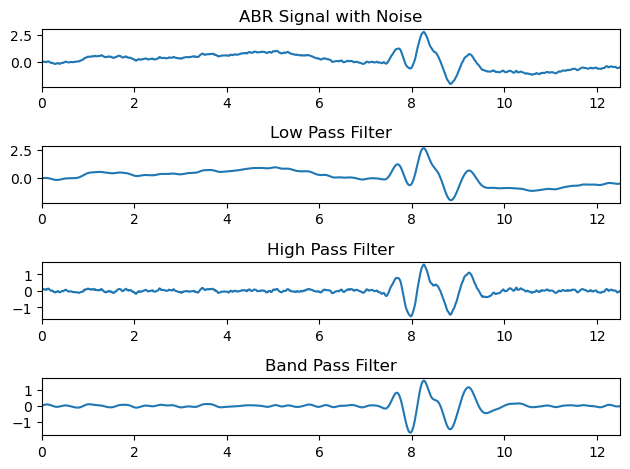

In [72]:
data = click[5]

b, a = scipy.signal.butter(3, 0.09, 'lowpass')
filteredLowPass = scipy.signal.filtfilt(b, a, data)

b, a = scipy.signal.butter(3, .02, 'highpass')
filteredHighPass = scipy.signal.filtfilt(b, a, data)

b, a = scipy.signal.butter(3, [.02, .09], 'band')
filteredBandPass = scipy.signal.filtfilt(b, a, data)

#High pass 30Hz
#Low Pass 3kHz


#plot the difference

plt.subplot(411)
plt.plot(n, data)
plt.title("ABR Signal with Noise")
plt.margins(0, .05)


plt.subplot(412)
plt.plot(n, filteredLowPass)
plt.title("Low Pass Filter")
plt.margins(0, .05)


plt.subplot(413)
plt.plot(n, filteredHighPass)
plt.title("High Pass Filter")
plt.margins(0, .05)


plt.subplot(414)
plt.plot(n, filteredBandPass)
plt.title("Band Pass Filter")
plt.margins(0, .05)


plt.tight_layout()
plt.show()

In [1]:
left = df_all[df_all['L/R'] == "L"]["ABR"]
b, a = scipy.signal.butter(3, [.033, .06], 'band')


fig, ax = plt.subplots(2,1, figsize=(10,7))
i = 0
c = 0

plt.title("{Left ear} ABR Signal with Noise")
plt.grid()
plt.xlim(3,10)
for i in range(14):
    plt.plot(n, left[i], color = 'black', label = 'unfiltered')
    i +=1

# plt.plot(n, left[29], 'r')

# i = 0
# counter = 0
# for counter in range(len(left)):
#     for i in range(14):
#         bp_left = scipy.signal.lfilter(b, a, left[i])
#         plt.subplot(212)
#         plt.title("{Left ear} ABR Signal with Noise")
#         plt.plot(n, bp_left)
#         plt.grid()
#         plt.xlim(3,10)
#     i =+ 14





NameError: name 'df_all' is not defined

NameError: name 'leftt' is not defined

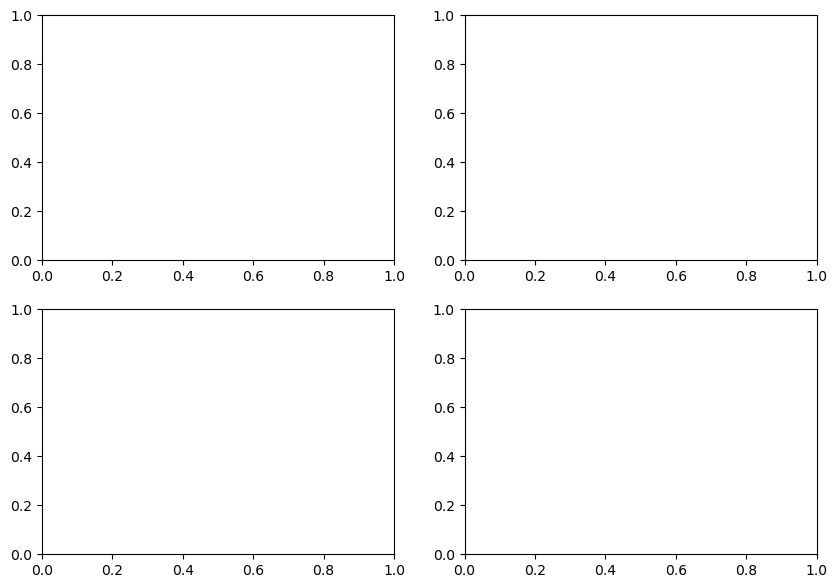

In [26]:
#Band pass filters



#*********TRY FILTFILT
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html

#left ear
# left = df_all.loc[df_all['L/R'] == "L"]["ABR"].to_numpy

# b, a = scipy.signal.butter(3, [.033, .06], 'band')
# bp_left = scipy.signal.lfilter(b, a, left)
#High pass 30Hz
#Low Pass 3kHzplt.subplot(211)

fig, ax = plt.subplots(2, 2, figsize=(10,7))

plt.subplot(221)
plt.plot(n, leftt)
plt.title("{Left ear} ABR Signal with Noise")
plt.grid()
plt.xlim(6,10)

plt.subplot(222)
plt.plot(n, bp_left)
plt.title("Band Pass Filter")
plt.grid()
plt.xlim(6,10)


#right ear
right = df_all.loc[df_all['L/R'] == "R"]

b, a = scipy.signal.butter(3, [.033, .06], 'band')
bp_right = scipy.signal.lfilter(b, a, rightt)
#High pass 30Hz
#Low Pass 3kHzplt.subplot(211)


plt.subplot(223)
plt.plot(n, rightt)
plt.title("{right ear} ABR Signal with Noise")
plt.grid()
plt.xlim(6,10)

plt.subplot(224)
plt.plot(n, bp_right)
plt.title("Band Pass Filter")
plt.grid()
plt.xlim(6,10)

plt.show()

In [ ]:
### Tune with Machine Learning?

# Note
FILTERED RESPONSE LOSES MAXIMUM PEAK AMPLITUDE DATA
https://swharden.com/blog/2020-09-23-signal-filtering-in-python/

In [ ]:
latency_labels = np.zeros(samples)
#for i in range(len(df[0])):     



# Find the threshold point of ABR "wave 1" 
### Wave 1 is the first major peak of each waveform which can be seen in this example at around 7.8 ms

### we will also want to the know the maximum (amplitude value) and latency (time value) of wave 1 for each wave
#The appearence or non appearence  of a significant peak 1 accross decreasing intesity (90->85--> .... --> 50 decibles) will help to determine the hearing threshold for the hearing test.